In [1]:
import numpy as np
from hashlib import md5
from paddle import fluid
from collections import Counter
from itertools import chain
import random
from multiprocessing import cpu_count, pool

In [2]:
class SubWordTools:
    def __init__(self, id2word_dict, threads=0, sub_ngrams=(3,4,5,6), ngrams=(2,), sequence_length=3000, hash_bins=1e6):
        self.id2word_dict = id2word_dict
        self.threads = threads
        self.ngrams = ngrams
        self.sub_ngrams = sub_ngrams
        self.sequence_length = sequence_length
        self.hash_bins = int(hash_bins)
        
    def fit(self, data):
        start = time.time()
        if self.threads <= 0:
            threads = cpu_count() - 1
        else:
            threads = self.threads
        p = pool.Pool(threads)
        data = p.map(self.gen_ngrams, data)
        p.close()
        p.join()
        print('pre process data done. cost time %.4f'%(time.time() - start))
        return data

    def gen_subs(self, word):
        word = '<' + word + '>'
        len_word = len(word)
        sub_words = []
        for n in self.sub_ngrams:
            if len_word >= n:
                end_index = len_word - n + 1
                for i in range(end_index):
                    sub_words.append(word[i:i+n])
        return sub_words

    def gen_ngrams(self, sequence):
        """
        get the ngrams elements of the sequence. The sequence should be a list of encoded words.
        :param sequence:
        :return: the hashing code of subs, the length of words and ngrams.
        """
        subs = []
        len_seq = len(sequence)
        for w in sequence:
            subs += [self.gen_hash_code(sub) for sub in self.gen_subs(self.id2word_dict[w])]
        for n in self.ngrams:
            for i in range(len_seq - n + 1):
                grams = sequence[i:i+n]
                grams = self.concat([self.id2word_dict[id] for id in grams])
                subs += [self.gen_hash_code(sub) for sub in self.gen_subs(grams)]
        len_subs = len(subs)
        if len_subs >= self.sequence_length:
            subs = subs[:self.sequence_length]
            length = self.sequence_length
        else:
            length = len(subs) + 0.001 # to avoid divided by 0
            subs = subs + [0] * (self.sequence_length - len_subs)
        return subs, length
        
    def padding(self, subs):
        len_subs = len(subs)
        if len_subs >= self.sequence_length:
            subs = subs[:self.sequence_length]
            length = self.sequence_length
        else:
            length = len(subs) + 0.001 # to avoid divided by 0
            subs = subs + [0] * (self.sequence_length - len_subs)
        return subs, length

    def concat(self, word_list):
        """
        concatenate the string in word_list, with ' ' as the partition.
        :param word_list:
        :return: concatenated string
        """
        grams = ''
        for ind, word in enumerate(word_list):
            grams += word
            if ind < len(word_list) - 1:
                grams += ' '
        return grams

    def gen_hash_code(self, label):
        """
        get the hash code of a label
        :param label:
        :return:
        """

        def hashing(word):
            return int(md5(word.encode()).hexdigest(), 16)
        code = hashing(label) % (self.hash_bins - 1) + 1
        return code

    def build_data(self, data, labels=None, batch_size=32, shuffle=True):
        """
        to define a generator to reduce the memory cost
        :param labels:
        :param data:
        :param batch_size:
        :return:
        """
        shuffle_id = list(range(len(data)))
        if shuffle:
            random.shuffle(shuffle_id)
        batch_data = []
        if labels is not None:
            batch_label = []
        for id in shuffle_id:
            batch_data.append(data[id])
            if labels is not None:
                batch_label.append(labels[id])
            if len(batch_data) == batch_size:
                if labels is not None:
                    yield batch_data, batch_label
                    batch_data = []
                    batch_label = []
                else:
                    yield batch_data
                    batch_data = []

        if len(batch_data) > 0:
            if labels is not None:
                yield batch_data, batch_label
            else:
                yield batch_data

In [3]:
class FastTextC_pp:
    """
    使用paddlepaddle框架编写
    output_dim: number of classed of text classification
    min_count: only the words with frequency higher than min_count will be considered to be trained.
    embedding_size: dimensionality of word embedding
    sub_ngrams: the value of n to consider ngrams of subwords.
    ngrams: the value of n to consider ngrams features of documents
    skip_ratio: for some words with high frequency, the redundant training of them will not get better embeddings while
    hash_bins: the length of hash features of subwords.
    sequence_length: the length of subwords to be considered when document is transferred, if the subwords in the document
    is not enough sequence_length, the last length will be padded with 0
    skip_ratio: for some words with high frequency, the redundant training of them will not get better embeddings while
    cost extra time. These words that exceed skip probability will not be trained every meeting. Instead, they will be skipped
    in training with probability 1 - (skip_ratio / f(w)) ^ 1/2, where f(w) = Count(w) / Count(all words)
    learning_rate: learning rate of optimizer
    use_gpu: whether or not to use gpu for training
    """
    def __init__(self, output_dim,
                 embedding_size=100,
                 min_count=5,
                 sub_ngrams=(3,4,5,6),
                 ngrams=(2,),
                 skip_ratio=1.0,
                 hash_bins=1e5,
                 sequence_length=10000,
                 learning_rate=0.001,
                 use_gpu=False,
                 threads=0,
                 ):
        self.output_dim = output_dim
        self.min_count = min_count
        self.embedding_size = embedding_size
        self.sub_ngrams = sub_ngrams
        self.ngrams = ngrams
        self.skip_ratio = skip_ratio
        self.hash_bins = int(hash_bins)
        self.sequence_length = sequence_length
        self.learning_rate = learning_rate
        self.use_gpu = use_gpu
        self.threads = threads
        self.deployed = False
        if self.use_gpu:
            self.place = fluid.CUDAPlace(0)
        else:
            self.place = fluid.CPUPlace()

    def fit(self, data):
        """
        fit the data, get the vocabulary and vocabulary size, the code the data
        :param data: text string or splitted words. Note that the data should be a (batch, length)
        form, where the length dim corresponds the text string or splitted words.
        :return: the fitted data
        """
        try:
            data = [line.split(' ') for line in data]
            print("The form of input text is [text1, text2, ...].")
        except AttributeError:
            print("The form of input text is [[word11, word12, ...], [word21, word22, ...]].")
        data = [[word.lower() for word in line] for line in data]
        words_counter = [(word, count) for word, count in Counter(chain(*data)).most_common() if count >= self.min_count]
        self.vocab_size = len(words_counter)
        # generate 3 different dicts to store:
        # word to id
        # word to id's frequency
        # id to word
        self.word2id_dict = {word: id for id, (word, _) in enumerate(words_counter)}
        self.id2word_dict = {id: word for id, (word, _) in enumerate(words_counter)}
        self.word2id_freq = {id: freq for id, (_, freq) in enumerate(words_counter)}
        # transfer data to ids
        data = [[self.word2id_dict[word] for word in line if word in self.word2id_dict.keys()] for line in data]
        # subsampling, reduce the size of the data to boost the training process
        data = self.subsampling(data)
        self.subwordtool = SubWordTools(self.id2word_dict, self.threads, self.sub_ngrams, self.ngrams, self.sequence_length, self.hash_bins)
        data = self.subwordtool.fit(data)
        return data

    def subsampling(self, data):
        """
        discard some words according to their frequency. The higher the more likely to be discarded.
        :param data:
        :return:
        """
        total_num = np.sum([freq for freq in self.word2id_freq.values()])
        skip_prob = {id: 1 - (self.skip_ratio / freq * total_num) ** 0.5 for (id, freq) in self.word2id_freq.items()}
        return [[word for word in line if np.random.rand() > skip_prob[word]] for line in data]

    def forward(self, inputs, words_count, label=None):
        """
        :param inputs:
        :param words_count:
        :param label:
        :return:
        """
        sequence_emb = fluid.embedding(inputs, size=[self.hash_bins, self.embedding_size], is_sparse=True, padding_idx=0, param_attr='shred_w')
        sequence_emb = fluid.layers.reduce_sum(sequence_emb, dim=1)
        words_count = fluid.layers.reshape(words_count, [words_count.shape[0], 1])
        sequence_emb = fluid.layers.elementwise_div(sequence_emb, words_count)
        pred = fluid.layers.fc(input=[sequence_emb], size=self.output_dim, act='softmax')

        if labels is not None:
            label = fluid.layers.argmax(label, axis=1)
            label = fluid.layers.reshape(label, [-1, 1])
            acc = fluid.layers.accuracy(input=pred, label=label)
            return pred, acc
        else:
            return pred

    def train(self, inputs, label, epochs=5, batch_size=32):
        if not self.deployed:
            input_var = fluid.data(name='inputs', shape=[None, self.sequence_length], dtype='int64')
            word_count_var = fluid.data(name='word_count', shape=[None], dtype='float32')
            label_var = fluid.data(name='label', shape=[None, self.output_dim], dtype='int64')

            self.main_program = fluid.default_main_program()
            self.startup_program = fluid.default_startup_program()

            pred, self.acc = self.forward(input_var, word_count_var, label_var)
            self.pred = pred
            label_var = fluid.layers.argmax(label_var, axis=1)
            label_var = fluid.layers.reshape(label_var, [-1, 1])
            loss = fluid.layers.cross_entropy(pred, label_var, soft_label=False)
            self.loss = fluid.layers.reduce_mean(loss)
            optimizer = fluid.optimizer.Adam(learning_rate=self.learning_rate)

            self.test_program = self.main_program.clone(for_test=True)

            optimizer.minimize(self.loss)

            self.exe = fluid.Executor(self.place)
            self.exe.run(self.startup_program)

            self.deployed = True

        # 在静态图中输入向量是根据向量的名字识别的，feed_order中名字的顺序对应的就是在执行操作时送入数据的顺序
        feed_order = ['inputs', 'word_count', 'label']
        # 以下两行起到了传递数据的作用，注意feed_order和feed_var_list_loop中的量是一一对应的
        feed_var_list_loop = [self.main_program.global_block().var(var_name) for var_name in feed_order]
        self.feeder = fluid.DataFeeder(feed_list=feed_var_list_loop, place=self.place)

        self.history = {'loss': [], 'accuracy': []}
        for epoch in range(epochs):
            data = self.subwordtool.build_data(inputs, label, batch_size=batch_size)
            ave_loss = 0
            ave_acc = 0
            step = 0
            start = time.time()
            total_step = int(np.ceil(len(inputs) / batch_size))
            for data_count_batch, labels_batch in data:
                data_batch = [line[0] for line in data_count_batch]
                num_batch = [line[1] for line in data_count_batch]
                data_batch = np.array(data_batch).astype('int64')
                num_batch = np.array(num_batch).astype('float32')
                labels_batch = np.array(labels_batch).astype('int64')
                loss_, accuracy = self.exe.run(self.main_program, feed=self.feeder.feed(zip(data_batch, num_batch, labels_batch)), fetch_list=[self.loss, self.acc])
                step += 1
                ave_loss = (ave_loss * (float(step) - 1.0) + loss_[0]) / float(step)
                ave_acc = (ave_acc * (float(step) - 1.0) + accuracy[0]) / float(step)
                if step % 10 == 0 and step < total_step:
                    print('epoch: {} - ETA: {:.2f} - step: {} / {} - acc: {:.4f} - loss: {:.4f}'.format(
                        epoch + 1,  (time.time() - start) / step * (total_step - step), str(step).ljust(len(str(total_step))),
                        total_step, accuracy[0], loss_[0]))
                if step == total_step:
                    print('epoch: {} done - time cost: {:.2f} -ave acc: {:.4f} - ave loss: {:.4f}'.format(
                        epoch + 1, time.time() - start, ave_acc, ave_loss))
            self.history['loss'].append(ave_loss)
            self.history['accuracy'].append(ave_acc)

    def evaluate(self, test_inputs, test_labels, batch_size=32):
        """
        evaluate the model, return the accuracy.
        :param test_data:
        :param test_labels:
        :param batch_size:
        :return:
        """
        test_program = self.test_program
        data = self.subwordtool.build_data(test_inputs, test_labels, batch_size=batch_size)
        ave_loss = 0
        ave_acc = 0
        step = 0
        start = time.time()
        total_step = int(np.ceil(len(test_inputs) / batch_size))
        for data_count_batch, labels_batch in data:
            data_batch = [line[0] for line in data_count_batch]
            num_batch = [line[1] for line in data_count_batch]
            data_batch = np.array(data_batch).astype('int64')
            num_batch = np.array(num_batch).astype('float32')
            labels_batch = np.array(labels_batch).astype('int64')
            loss_, accuracy = self.exe.run(test_program,
                                           feed=self.feeder.feed(zip(data_batch, num_batch, labels_batch)),
                                           fetch_list=[self.loss, self.acc])
            step += 1
            ave_loss = (ave_loss * (float(step) - 1.0) + loss_[0]) / float(step)
            ave_acc = (ave_acc * (float(step) - 1.0) + accuracy[0]) / float(step)
            if step % 10 == 0 and step < total_step:
                print('ETA: {:.2f} - step: {} / {} - acc: {:.4f} - loss: {:.4f}'.format(
                    (time.time() - start) / step * (total_step - step),
                    str(step).ljust(len(str(total_step))),
                    total_step, accuracy[0], loss_[0]))
            if step == total_step:
                print('Done - time cost: {:.2f} -ave acc: {:.4f} - ave loss: {:.4f}'.format(
                    time.time() - start, ave_acc, ave_loss))

    def predict_prob(self, inputs, batch_size=32):
        """
        predict the probability of labels of inputs
        :param inputs:
        :param batch_size:
        :return:
        """
        test_program = self.test_program
        data = self.subwordtool.build_data(inputs, batch_size=batch_size, shuffle=False)
        pred_labels = []
        for data_count_batch in data:
            data_batch = [line[0] for line in data_count_batch]
            num_batch = [line[1] for line in data_count_batch]
            data_batch = np.array(data_batch).astype('int64')
            num_batch = np.array(num_batch).astype('float32')
            labels_batch = np.zeros((data_batch.shape[0], self.output_dim)).astype('int64')
            pred, = self.exe.run(test_program,
                                           feed=self.feeder.feed(zip(data_batch, num_batch, labels_batch)),
                                           fetch_list=[self.pred])
            pred = pred.tolist()
            for line in pred:
                pred_labels.append(line)
        return pred_labels

# 运行一下

## 读入数据

In [4]:
import chardet
import time

def one_hot_labeling(labels):
    """
    get the one hot form of labels
    :param labels:
    :return:
    """
    label_set = [label for label in set(labels)]
    label_code = {label: x for x, label in enumerate(label_set)}
    one_hots = []
    for label in labels:
        tem = [0] * len(label_set)
        tem[label_code[label]] = 1
        one_hots.append(tem)
    return one_hots, label_set

folder_prefix = 'r52/'
x_train = list(open(folder_prefix + "train.txt", 'rb').readlines())
x_test = list(open(folder_prefix + "test.txt", 'rb').readlines())
x_all = []
train_size = len(x_train)
x_all = x_all + x_train + x_test

le = len(x_all)
for i in range(le):
    encode_type = chardet.detect(x_all[i])
    x_all[i] = x_all[i].decode(encode_type['encoding'])  # 进行相应解码，赋给原标识符（变量
labels = [s.split()[0] for s in x_all]
labels, label_set = one_hot_labeling(labels)
x_all = [s.split()[1:] for s in x_all]

## 训练

In [5]:
embedding_size = 100
learning_rate = 0.01
output_dim = len(labels[0])
sequence_length = 1000
hash_bins = 5*1e6
epochs = 5

ftc = FastTextC_pp(output_dim=output_dim, embedding_size=embedding_size, ngrams=(2,),
                   sequence_length=sequence_length, min_count=5, hash_bins=hash_bins, 
                   use_gpu=True, sub_ngrams=(3, 4, 5), skip_ratio=0.001, learning_rate=learning_rate)
data = ftc.fit(x_all)
ftc.train(data[:train_size], labels[:train_size], epochs=epochs, batch_size=64)

The form of input text is [[word11, word12, ...], [word21, word22, ...]].
pre process data done. cost time 17.4581
epoch: 1 - ETA: 6.49 - step: 10  / 103 - acc: 0.5625 - loss: 3.1527
epoch: 1 - ETA: 5.37 - step: 20  / 103 - acc: 0.5469 - loss: 1.9049
epoch: 1 - ETA: 4.67 - step: 30  / 103 - acc: 0.7656 - loss: 1.1624
epoch: 1 - ETA: 3.97 - step: 40  / 103 - acc: 0.5938 - loss: 1.6389
epoch: 1 - ETA: 3.31 - step: 50  / 103 - acc: 0.6406 - loss: 1.4624
epoch: 1 - ETA: 2.68 - step: 60  / 103 - acc: 0.7500 - loss: 1.1319
epoch: 1 - ETA: 2.04 - step: 70  / 103 - acc: 0.7969 - loss: 0.9184
epoch: 1 - ETA: 1.42 - step: 80  / 103 - acc: 0.8594 - loss: 0.7913
epoch: 1 - ETA: 0.80 - step: 90  / 103 - acc: 0.7344 - loss: 0.9819
epoch: 1 - ETA: 0.18 - step: 100 / 103 - acc: 0.8125 - loss: 0.7661
epoch: 1 done - time cost: 6.30 -ave acc: 0.7113 - ave loss: 1.4522
epoch: 2 - ETA: 5.56 - step: 10  / 103 - acc: 0.9531 - loss: 0.2856
epoch: 2 - ETA: 5.03 - step: 20  / 103 - acc: 0.8750 - loss: 0.4554
e

2021-07-23 20:52:26,439-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2021-07-23 20:52:26,953-INFO: generated new fontManager


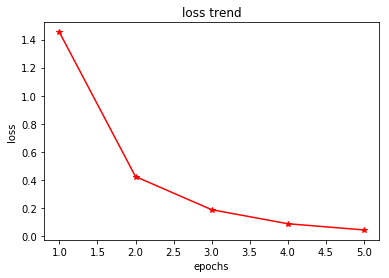

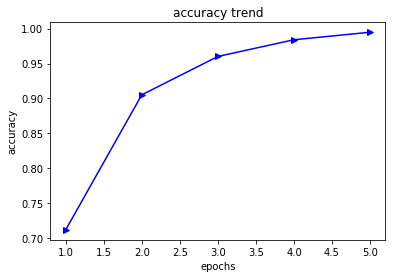

In [6]:
# 绘出loss，accuracy的变化趋势
%matplotlib inline
import matplotlib.pyplot as plt
epochs = [i+1 for i in range(epochs)]
history = ftc.history
plt.plot(epochs, history['loss'], 'r-*')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss trend')
plt.show()
plt.plot(epochs, history['accuracy'], 'b->')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy trend')
plt.show()

## 测试

In [7]:
ftc.evaluate(data[train_size:], labels[train_size:], batch_size=32)

ETA: 0.51 - step: 10 / 81 - acc: 0.8750 - loss: 0.4942
ETA: 0.42 - step: 20 / 81 - acc: 0.8438 - loss: 0.6506
ETA: 0.35 - step: 30 / 81 - acc: 1.0000 - loss: 0.0775
ETA: 0.28 - step: 40 / 81 - acc: 0.9688 - loss: 0.1666
ETA: 0.21 - step: 50 / 81 - acc: 0.8438 - loss: 0.5006
ETA: 0.14 - step: 60 / 81 - acc: 0.9688 - loss: 0.1155
ETA: 0.08 - step: 70 / 81 - acc: 0.9375 - loss: 0.2690
ETA: 0.01 - step: 80 / 81 - acc: 0.9062 - loss: 0.4072
Done - time cost: 0.57 -ave acc: 0.9309 - ave loss: 0.2848


# 预测

In [8]:
test_docs = data[500:510]
test_labels = labels[500:510]
prob = ftc.predict_prob(test_docs)
test_labels = np.argmax(test_labels, axis=1)
pred_labels = np.argmax(prob, axis=1)
for i, j in zip(test_labels, pred_labels):
    print('True label is {}, Predicted label is {}'.format(label_set[i], label_set[j]))

True label is earn, Predicted label is earn
True label is earn, Predicted label is earn
True label is earn, Predicted label is earn
True label is earn, Predicted label is earn
True label is earn, Predicted label is earn
True label is cpi, Predicted label is cpi
True label is copper, Predicted label is copper
True label is earn, Predicted label is earn
True label is acq, Predicted label is acq
True label is iron-steel, Predicted label is iron-steel
